In [1]:
import pandas as pd

In [3]:
# Load data
post_summary = pd.read_excel("Post Summary.xlsx")

In [5]:
# Check which rows are causing trouble
invalid_times = post_summary[~post_summary['createdTime'].str.contains(r'^\d{4}-\d{2}-\d{2}T', na=False)]
print(invalid_times[['createdTime']])

                                             createdTime
13426                                                NaN
13427                                                NaN
13428                                                NaN
13429                                          88_x000D_
13438   Ã Â¤Â¯Ã Â¤Â¹Ã Â¤Â¾Ã Â¤â€š Ã Â¤ÂªÃ Â¥â€¡ Ã Â¤Å...
13439   Ã Â¤â€”Ã Â¤Â¹Ã Â¤Â°Ã Â¤Â¾Ã Â¤Â Ã Â¤â€¢Ã Â¥â‚...
13440                         I want tell you about hope
13441                                                NaN
13442                                                NaN
13443                                 you can have ideas
13444                             she not attached to it
13445                                                NaN
13446                                                NaN
13447                                         178_x000D_


In [6]:
# Keep only valid datetime strings (basic pattern match for ISO format)
post_summary = post_summary[post_summary['createdTime'].str.contains(r'^\d{4}-\d{2}-\d{2}T', na=False)]

# Now safely convert
post_summary['createdTime'] = pd.to_datetime(post_summary['createdTime'], errors='coerce')

In [7]:
post_summary = post_summary.dropna(subset=['createdTime'])

In [51]:
post_summary['postedBy'].unique()

array(['Flipkart', 'Amazon India', 'Snapdeal', 'Myntra',
       'Bengaluru Traffic Police', 'Hyderabad Traffic Police',
       'Kolkata Traffic Police', 'Idea', 'Tata Docomo', 'Aircel India',
       'Fortis Healthcare', 'Kokilaben Dhirubhai Ambani Hospital',
       'Apollo Hospitals', 'Narendra Modi', 'Rahul Gandhi',
       'Arvind Kejriwal'], dtype=object)

In [9]:
traffic_pages = ["Bengaluru Traffic Police", "Kolkata Traffic Police", "Hyderabad Traffic Police"]
traffic_posts = post_summary[post_summary['postedBy'].isin(traffic_pages)]


In [10]:
traffic_pages

['Bengaluru Traffic Police',
 'Kolkata Traffic Police',
 'Hyderabad Traffic Police']

In [50]:
traffic_posts['postedBy'].unique()

array(['Bengaluru Traffic Police', 'Hyderabad Traffic Police',
       'Kolkata Traffic Police'], dtype=object)

In [12]:
def get_bucket(datetime_obj):
    return (datetime_obj.hour * 60 + datetime_obj.minute) // 15 + 1  # +1 for 1-based indexing

traffic_posts['timeBucket'] = traffic_posts['createdTime'].apply(get_bucket)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6100\1604022497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_posts['timeBucket'] = traffic_posts['createdTime'].apply(get_bucket)


In [13]:
bucket_counts = traffic_posts.groupby(['postedBy', 'timeBucket']).size().unstack(fill_value=0)


In [14]:
bucket_counts

timeBucket,3,5,7,8,9,10,11,12,13,14,...,83,84,85,86,89,90,91,93,94,96
postedBy,,,,,,,,,,,,,,,,,,,,,
Bengaluru Traffic Police,1,2,0,2,13,17,51,95,97,84,...,0,0,0,0,2,0,0,0,0,0
Hyderabad Traffic Police,0,1,1,0,1,2,5,3,10,4,...,4,3,1,3,1,4,1,1,1,1
Kolkata Traffic Police,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [17]:
# Ensure timeBucket ranges from 1 to 96 for all pages
bucket_counts = traffic_posts.groupby(['postedBy', 'timeBucket']).size().unstack(fill_value=0)

# Reindex columns to ensure all 96 buckets are present
bucket_counts = bucket_counts.reindex(columns=range(1, 97), fill_value=0)

In [18]:
bucket_counts

timeBucket,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
postedBy,,,,,,,,,,,,,,,,,,,,,
Bengaluru Traffic Police,0,0,1,0,2,0,0,2,13,17,...,0,0,2,0,0,0,0,0,0,0
Hyderabad Traffic Police,0,0,0,0,1,0,1,0,1,2,...,0,0,1,4,1,0,1,1,0,1
Kolkata Traffic Police,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


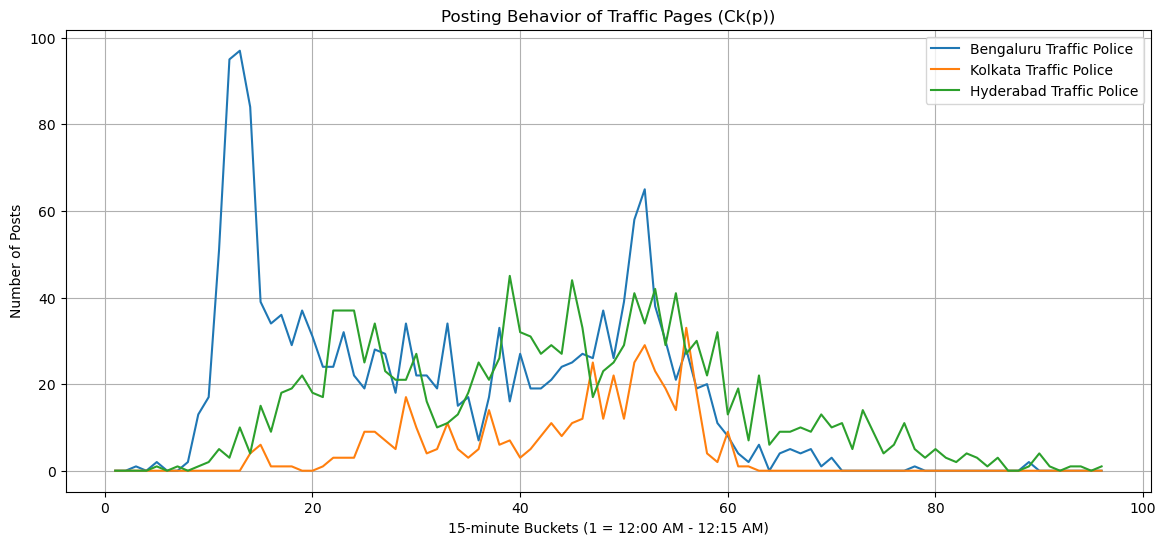

In [19]:
plt.figure(figsize=(14, 6))
for page in traffic_pages:
    plt.plot(range(1, 97), bucket_counts.loc[page], label=page)

plt.xlabel("15-minute Buckets (1 = 12:00 AM - 12:15 AM)")
plt.ylabel("Number of Posts")
plt.title("Posting Behavior of Traffic Pages (Ck(p))")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
comments_df = pd.read_excel("Comments.xlsx")
comments_df.head()

,pid,commentsText
0,2089,god gift?#+@2013 12 30T06:53:46+0000Hello wher...
1,2090,Dhannjay bhai NAYA SAAL MUBARAK HO ?#+@2014 01...
2,2093,That has happened to me when I ordered Nexus 4...
3,2097,after my yesterday s complain f***** msg me th...
4,2103,I ordered a product on 21st December 2013(it i...


In [52]:
# Filter for relevant e-commerce pages
ecom_pages = ["Flipkart", "Amazon India", "Snapdeal", "Myntra"]
ecom_posts = post_summary[post_summary['postedBy'].isin(ecom_pages)]

In [53]:
post_summary = pd.read_excel("Post Summary.xlsx")
post_summary = post_summary[post_summary['createdTime'].str.contains(r'^\d{4}-\d{2}-\d{2}T', na=False)]
post_summary['createdTime'] = pd.to_datetime(post_summary['createdTime'], errors='coerce')
post_summary = post_summary.dropna(subset=['createdTime'])

In [54]:
# Join on pid
merged_df = pd.merge(comments_df, ecom_posts[['pid', 'postedBy']], on='pid', how='inner')

In [55]:
merged_df['postedBy'].unique()

array(['Flipkart', 'Amazon India', 'Snapdeal', 'Myntra'], dtype=object)

In [56]:
import re
from datetime import datetime

In [57]:
def extract_timestamps(text):
    if pd.isnull(text):
        return []
    
    # Split comments using the separator
    parts = re.split(r'\?\#\+\@', text)
    timestamps = []

    for part in parts:
        # Match timestamps like 2013 07 18T09:45:51+0000
        matches = re.findall(r'\d{4} \d{2} \d{2}T\d{2}:\d{2}:\d{2}\+0000', part)
        for ts in matches:
            try:
                dt = datetime.strptime(ts, '%Y %m %dT%H:%M:%S+0000')
                timestamps.append(dt)
            except:
                continue
    return timestamps


In [58]:
# Apply function
merged_df['commentTimestamps'] = merged_df['commentsText'].apply(extract_timestamps)

In [59]:
merged_df['commentsText'].sample(3).values

array(['Nice?#+@2013 03 21T06:34:32+0000Only on Myntra com     ?#+@2013 03 24T15:49:37+0000',
       'Fb par bhi dukan chalate ho kya?#+@2013 07 24T05:22:00+0000They sell faulty products  Do not ever buy a product from them     ?#+@2013 07 24T05:33:22+0000Dear Snapdeal i am Loyal and regular buyer of your website      *\n\nThis is my order id\n1130228671\n\nAnd i am absolutely surprised when it showing me the estimated shipping\ndate is 31st July 2013 for my Micromax Phone  I purchased with you because\ni expected that you guys will make the faster delivery as like\nflipkart com  Coz i really really appreciated the\nflipkart com delivery they absolutely delivered the items within 5 working\ndays Since order     AND HERE YOU ARE SHOWING ME THAT 31ST JULY SHIPPING\nDATE   is this correct way to sustain in today s cut throat competitions\namong the online portals \n\nPlease improve it and try to deliver my UNDER said ordered items till 27th\nJuly at least  SO I CAN THINK NEXT TIME FOR YOU

In [60]:
# Explode commentTimestamps into separate rows
exploded = merged_df.explode('commentTimestamps').dropna(subset=['commentTimestamps'])

In [61]:
exploded

,pid,commentsText,postedBy,commentTimestamps
0,2089,god gift?#+@2013 12 30T06:53:46+0000Hello wher...,Flipkart,2013-12-30 06:53:46
0,2089,god gift?#+@2013 12 30T06:53:46+0000Hello wher...,Flipkart,2014-01-03 20:13:38
0,2089,god gift?#+@2013 12 30T06:53:46+0000Hello wher...,Flipkart,2013-12-30 06:50:47
0,2089,god gift?#+@2013 12 30T06:53:46+0000Hello wher...,Flipkart,2014-01-10 16:08:48
0,2089,god gift?#+@2013 12 30T06:53:46+0000Hello wher...,Flipkart,2013-12-30 08:02:15
...,...,...,...,...
1725,11763,So nice ?#+@2013 01 01T08:48:45+0000o ho n...,Myntra,2013-01-01 15:07:26
1725,11763,So nice ?#+@2013 01 01T08:48:45+0000o ho n...,Myntra,2013-01-03 15:55:31
1725,11763,So nice ?#+@2013 01 01T08:48:45+0000o ho n...,Myntra,2013-01-04 03:40:23
1725,11763,So nice ?#+@2013 01 01T08:48:45+0000o ho n...,Myntra,2013-01-04 20:00:09


In [62]:
exploded['postedBy'].unique()

array(['Flipkart', 'Amazon India', 'Snapdeal', 'Myntra'], dtype=object)

In [63]:
# Convert timestamps to 15-min bucket (1-96)
def get_bucket(dt):
    return (dt.hour * 60 + dt.minute) // 15 + 1

In [64]:
exploded['timeBucket'] = exploded['commentTimestamps'].apply(get_bucket)

In [65]:
# Group by postedBy and timeBucket
bucket_counts = exploded.groupby(['postedBy', 'timeBucket']).size().unstack(fill_value=0)

# Reindex to ensure all 96 time buckets
bucket_counts = bucket_counts.reindex(columns=range(1, 97), fill_value=0)

In [66]:
bucket_counts

timeBucket,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
postedBy,,,,,,,,,,,,,,,,,,,,,
Amazon India,0,0,0,1,1,2,0,1,2,1,...,1,0,1,0,0,0,0,0,1,0
Flipkart,2,0,1,5,3,1,1,0,0,4,...,1,1,1,1,0,0,0,0,0,2
Myntra,1,2,5,3,2,2,8,6,10,8,...,1,2,1,5,1,2,2,7,4,8
Snapdeal,2,3,3,16,5,2,8,9,6,7,...,5,1,1,0,2,0,5,0,0,0


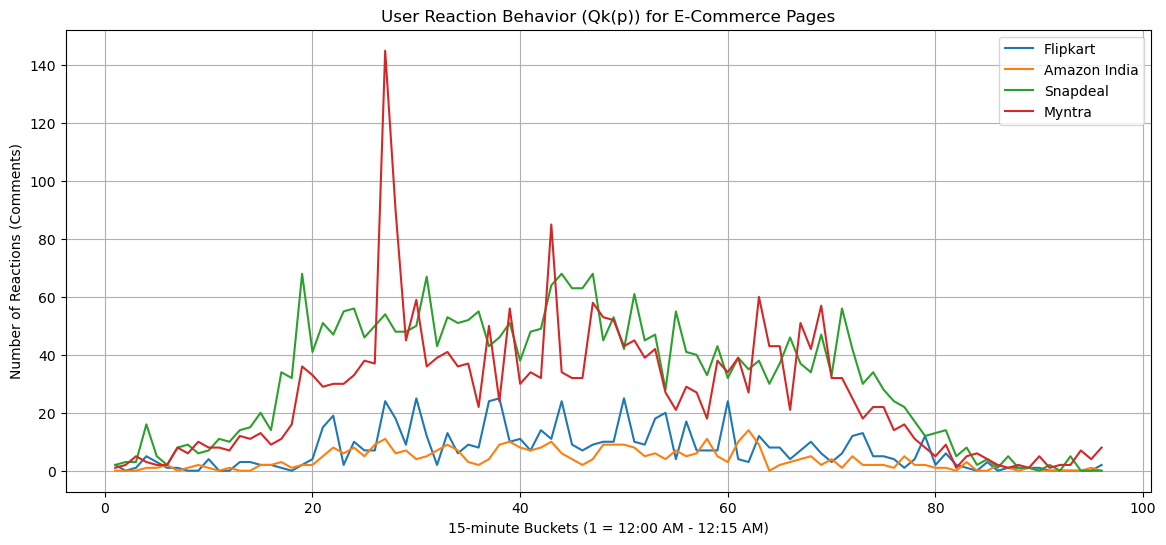

In [67]:
plt.figure(figsize=(14, 6))
for page in ecom_pages:
    plt.plot(range(1, 97), bucket_counts.loc[page], label=page)

plt.xlabel("15-minute Buckets (1 = 12:00 AM - 12:15 AM)")
plt.ylabel("Number of Reactions (Comments)")
plt.title("User Reaction Behavior (Qk(p)) for E-Commerce Pages")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
likes_per_category = post_summary.groupby('category')['likesCount'].mean().sort_values(ascending=False)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [69]:
# Remove commas and convert to numeric, force errors to NaN
post_summary['likesCount_clean'] = (
    post_summary['likesCount']
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.extract(r'(\d+\.?\d*)')  # Extract numeric portion
    .astype(float)
)


In [70]:
likes_per_category = (
    post_summary.groupby('category')['likesCount_clean']
    .mean()
    .sort_values(ascending=False)
)


In [71]:
likes_per_category

category
Retail and Consumer Merchandise    6.420120e+13
Clothing                           3.486615e+09
Website                            9.028132e+08
Politician                         3.232623e+04
Media/News/Publishing              1.096061e+04
Telecommunication                  3.335312e+03
Product/Service                    1.971882e+03
Hospital/Clinic                    6.011355e+02
Government Organization            1.587875e+02
Health/Medical/Pharmaceuticals     9.574897e+01
Name: likesCount_clean, dtype: float64

In [72]:
# Save to Excel
likes_per_category.to_excel('average_likes_per_category.xlsx', sheet_name='AvgLikes')

In [73]:
pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/00/09/abb305dce85911b8fba382926cfc57f2f257729e25937fdcc63f3a1a67f9/wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   ---------- ----------------------------- 81.9/299.9 kB 4.8 MB/s eta 0:00:01
   ----------------------- ---------------- 174.1/299.9 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 3.1 MB/s eta 0:00:01
   -------------------------------------- 299.9/299.9 kB 978.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [74]:
from wordcloud import WordCloud

In [75]:
# Optional: filter out missing messages
valid_posts = post_summary.dropna(subset=['message'])

In [76]:
# Group by postedBy
grouped = valid_posts.groupby('postedBy')

In [79]:
import os

In [82]:
# Ensure output directory exists
output_dir = 'wordclouds_by_organization'
os.makedirs(output_dir, exist_ok=True)

# Group by PostedBy and concatenate text
for org, group in post_summary.groupby('postedBy'):
    text = ' '.join(group['message'].dropna().astype(str))

    if text.strip():  # Only create word cloud if there's actual text
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis'
        ).generate(text)

        # Plot and save image
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout()

        # Clean file name
        file_name = f"{org.strip().replace(' ', '_').replace('/', '_')}.png"
        full_path = os.path.join(output_dir, file_name)
        plt.savefig(full_path, format='png')
        plt.close()

print("✅ Word clouds saved in:", output_dir)

✅ Word clouds saved in: wordclouds_by_organization
